In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import ast

In [104]:
# Seaborn 색상 팔레트 적용
palette = sns.color_palette("Set2")

In [105]:
# 📂 데이터 로딩
label_train = pd.read_csv("./data/preprocessed/train/train_label_preprocessed.csv")
merged_train = pd.read_csv("./data/preprocessed/train/merged_preprocessed.csv")
label_val = pd.read_csv("./data/preprocessed/validation/validation_label_preprocessed.csv")
merged_val = pd.read_csv("./data/preprocessed/validation/merged_preprocessed.csv")

In [106]:
sleep_train = merged_train.copy()
sleep_val = merged_val.copy()

# sleep1. sleep_midpoint_at_delta_norm

- 수면 중간지점과 자정과의 차이를 -12시간 ~ +12시간 범위로 변환합니다. 

In [107]:
# midpoint_at_delta 재계산
import numpy as np

# 수면 중간지점과 자정과의 차이를 다시 계산
def recalculate_sleep_midpoint_at_delta(row):
    delta_seconds = row['sleep_midpoint_at_delta']
    
    # 0~24시간 범위를 초과하는 경우 조정 (-12시간 ~ +12시간 범위로 변환)
    if delta_seconds > 12 * 3600:
        delta_seconds -= 24 * 3600
    
    return delta_seconds

# sleep_midpoint_at_delta 재계산 및 업데이트
sleep_train['sleep_midpoint_delta_norm'] = sleep_train.apply(recalculate_sleep_midpoint_at_delta, axis=1)
sleep_val['sleep_midpoint_delta_norm'] = sleep_val.apply(recalculate_sleep_midpoint_at_delta, axis=1)

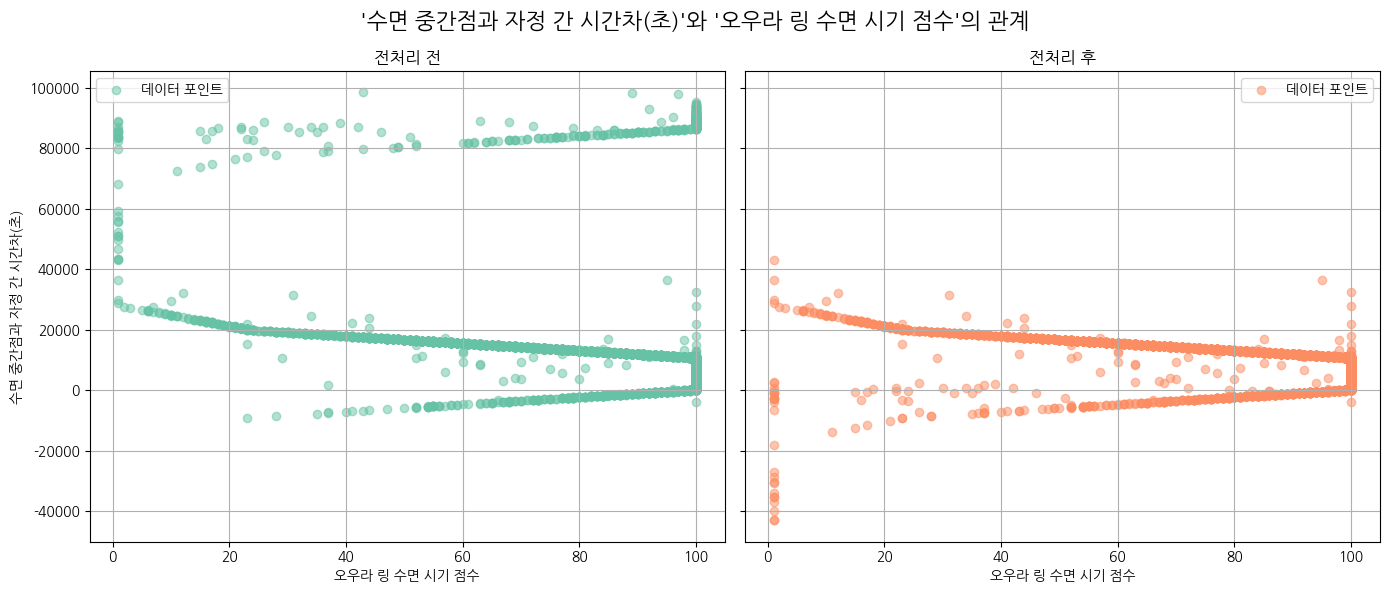

In [108]:
# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Y축 통일 (sharey=True)
fig.suptitle("'수면 중간점과 자정 간 시간차(초)'와 '오우라 링 수면 시기 점수'의 관계", fontsize=16)

# 첫 번째 산점도
axes[0].scatter(sleep_train['sleep_score_alignment'], sleep_train['sleep_midpoint_at_delta'], 
                color=palette[0], alpha=0.5, label='데이터 포인트')
axes[0].set_title("전처리 전")
axes[0].set_xlabel("오우라 링 수면 시기 점수")
axes[0].set_ylabel("수면 중간점과 자정 간 시간차(초)")
axes[0].legend()
axes[0].grid(True)

# 두 번째 산점도
axes[1].scatter(sleep_train['sleep_score_alignment'], sleep_train['sleep_midpoint_delta_norm'], 
                color=palette[1], alpha=0.5, label='데이터 포인트')
axes[1].set_title("전처리 후")
axes[1].set_xlabel("오우라 링 수면 시기 점수")  # X축 레이블 동일하게 유지
axes[1].legend()
axes[1].grid(True)

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

# sleep2. var_sleep_time_to_hr_lowest

- 사람별 수면 중 최저심박수에 도달하는 시간의 분산

In [109]:
def parse_hr_list(s):
    try:
        return ast.literal_eval(s) if isinstance(s, str) else []
    except:
        return []

In [110]:
def compute_time_to_hr_lowest(hr_list):
    if len(hr_list) == 0:
        return np.nan
    min_idx = np.argmin(hr_list)
    return min_idx * 5  # 5분 간격

sleep_train["sleep_hr_5min_interpolated"] = sleep_train["sleep_hr_5min_interpolated"].map(parse_hr_list)
sleep_val["sleep_hr_5min_interpolated"] = sleep_val["sleep_hr_5min_interpolated"].map(parse_hr_list)
sleep_train["sleep_time_to_hr_lowest"] = sleep_train["sleep_hr_5min_interpolated"].apply(compute_time_to_hr_lowest)
sleep_val["sleep_time_to_hr_lowest"] = sleep_val["sleep_hr_5min_interpolated"].apply(compute_time_to_hr_lowest)

def add_variance_feature(df, feature_col):
    person_var_df = df.groupby("EMAIL")[feature_col].var().reset_index()
    person_var_df.rename(columns={feature_col: f"var_{feature_col}"}, inplace=True)
    df = pd.merge(df, person_var_df, on="EMAIL", how="left")
    return df

sleep_train = add_variance_feature(sleep_train, "sleep_time_to_hr_lowest")
sleep_val = add_variance_feature(sleep_val, "sleep_time_to_hr_lowest")

# sleep3. median_sleep_temperature_delta

In [111]:
def add_median_feature(df, feature_col):
    person_var_df = df.groupby("EMAIL")[feature_col].var().reset_index()
    person_var_df.rename(columns={feature_col: f"median_{feature_col}"}, inplace=True)
    df = pd.merge(df, person_var_df, on="EMAIL", how="left")
    return df

sleep_train = add_median_feature(sleep_train, "sleep_temperature_delta")
sleep_val = add_median_feature(sleep_val, "sleep_temperature_delta")

# sleep4. median_sleep_hr_lowest

In [112]:
def add_median_feature(df, feature_col):
    person_var_df = df.groupby("EMAIL")[feature_col].median().reset_index()
    person_var_df.rename(columns={feature_col: f"median_{feature_col}"}, inplace=True)
    df = pd.merge(df, person_var_df, on="EMAIL", how="left")
    return df

sleep_train = add_median_feature(sleep_train, "sleep_hr_lowest")
sleep_val = add_median_feature(sleep_val, "sleep_hr_lowest")

# sleep5. sleep_rmssd_median

In [113]:
def parse_rmssd_list(s):
    try:
        return ast.literal_eval(s) if isinstance(s, str) else []
    except:
        return []

sleep_train['sleep_rmssd_5min_interpolated'] = sleep_train['sleep_rmssd_5min_interpolated'].map(parse_rmssd_list)
sleep_val['sleep_rmssd_5min_interpolated'] = sleep_val['sleep_rmssd_5min_interpolated'].map(parse_rmssd_list)

sleep_train["sleep_rmssd_median"] = sleep_train["sleep_rmssd_5min_interpolated"].apply(lambda x: np.median(x) if isinstance(x, list) and len(x) > 0 else np.nan)
sleep_val["sleep_rmssd_median"] = sleep_val["sleep_rmssd_5min_interpolated"].apply(lambda x: np.median(x) if isinstance(x, list) and len(x) > 0 else np.nan)

# sleep6.var_sleep_rmssd_median

In [114]:
sleep_train = add_variance_feature(sleep_train, "sleep_rmssd_median")
sleep_val = add_variance_feature(sleep_val, "sleep_rmssd_median")

In [115]:
def add_mean_feature(df, feature_col):
    person_var_df = df.groupby("EMAIL")[feature_col].mean().reset_index()
    person_var_df.rename(columns={feature_col: f"mean_{feature_col}"}, inplace=True)
    df = pd.merge(df, person_var_df, on="EMAIL", how="left")
    return df

# sleep6. var_sleep_awake

In [116]:
sleep_train = add_variance_feature(sleep_train, "sleep_awake")
sleep_val = add_variance_feature(sleep_val, "sleep_awake")

# sleep7. median_sleep_deep

In [117]:
sleep_train = add_median_feature(sleep_train, "sleep_deep")
sleep_val = add_median_feature(sleep_val, "sleep_deep")

# sleep8, 9. median_sleep_restless, var_sleep_restless

In [118]:
sleep_train = add_variance_feature(sleep_train, "sleep_restless")
sleep_val = add_variance_feature(sleep_val, "sleep_restless")
sleep_train = add_median_feature(sleep_train, "sleep_restless")
sleep_val = add_median_feature(sleep_val, "sleep_restless")

# sleep10, 11. median_sleep_light, var_sleep_light

In [119]:
sleep_train = add_variance_feature(sleep_train, "sleep_light")
sleep_val = add_variance_feature(sleep_val, "sleep_light")
sleep_train = add_median_feature(sleep_train, "sleep_light")
sleep_val = add_median_feature(sleep_val, "sleep_light")

# sleep12, 13. sleep_startpoint_delta_norm, sleep_endpoint_delta_norm

In [120]:
from datetime import datetime

# 자정과 timestamp의 차이(초)
def time_to_seconds_since_midnight(timestamp):
    dt = datetime.fromisoformat(timestamp[:-6])  # +09:00 타임존 offset 제거
    return dt.hour * 3600 + dt.minute * 60 + dt.second


sleep_train["sleep_startpoint_at_delta"] = sleep_train["sleep_bedtime_start"].apply(
    time_to_seconds_since_midnight
)
sleep_val["sleep_startpoint_at_delta"] = sleep_val["sleep_bedtime_start"].apply(
    time_to_seconds_since_midnight
)

sleep_train["sleep_endpoint_at_delta"] = sleep_train["sleep_bedtime_end"].apply(
    time_to_seconds_since_midnight
)
sleep_val["sleep_endpoint_at_delta"] = sleep_val["sleep_bedtime_end"].apply(
    time_to_seconds_since_midnight
)

# 자정 전의 시간이면 음수를 갖도록 수정
def adjust_delta_time(time):
    if time > 43200:
        time -= 86400
    return time


sleep_train["sleep_startpoint_delta_norm"] = sleep_train[
    "sleep_startpoint_at_delta"
].apply(adjust_delta_time)
sleep_val["sleep_startpoint_delta_norm"] = sleep_val[
    "sleep_startpoint_at_delta"
].apply(adjust_delta_time)
sleep_train["sleep_endpoint_delta_norm"] = sleep_train[
    "sleep_endpoint_at_delta"
].apply(adjust_delta_time)
sleep_val["sleep_endpoint_delta_norm"] = sleep_val[
    "sleep_endpoint_at_delta"
].apply(adjust_delta_time)

# activity1. median_activity_inactive

In [121]:
sleep_train = add_median_feature(sleep_train, "activity_inactive")
sleep_val = add_median_feature(sleep_val, "activity_inactive")

In [123]:
drop_columns = [
    'sleep_midpoint_at_delta',
    'sleep_score_alignment',
    'sleep_rmssd_median',
    'sleep_rem',
    'sleep_temperature_deviation',
    'sleep_temperature_delta',
    'max_zero_streak',
    'total_log_count',
    'zero_count_before',
    'zero_count_after',
    'sleep_time_to_hr_lowest',
    'rmssd_zero_count',
    'hr_zero_count',
    'sleep_midpoint_time',
    'sleep_period_id',
    'sleep_score_rem',
    'sleep_is_longest',
    'sleep_restless',
    'sleep_score',
    'sleep_score_efficiency',
    'sleep_endpoint_at_delta',
    'sleep_startpoint_at_delta',
    'sleep_score_disturbances',
    'sleep_score_total',
    'sleep_score_latency',
    'sleep_rmssd',
    'sleep_hr_lowest',
    'sleep_light',
    'sleep_score_deep',
    'sleep_hr_average',
    'sleep_onset_latency',
    'sleep_efficiency',
    'sleep_duration',
    'sleep_total',
    'sleep_awake',
]

sleep_train.drop(columns=drop_columns, inplace=True)
sleep_val.drop(columns=drop_columns, inplace=True)

In [124]:
sleep_train.to_csv("./data/engineered/train/merged_engineered.csv", index=False)
sleep_val.to_csv("./data/engineered/validation/merged_engineered.csv", index=False)
label_train.to_csv("./data/engineered/train/train_label_engineered.csv", index=False)
label_val.to_csv("./data/engineered/validation/validation_label_engineered.csv", index=False)